In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import load_model
from keras.layers import Input
import pickle as pkl
import json
import requests
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [5]:
apikey = "L8KVYT9ERPAC16J7"
symbol = "MSFT"
function = "TIME_SERIES_DAILY"
outputsize = "full"
api = "https://www.alphavantage.co/query?function={}&symbol={}&outputsize={}&apikey={}".format(function,symbol,outputsize,apikey)

def get_realtime_stock_data():
    responses = requests.get(api)
    raw_data = responses.json()
    time_series = raw_data["Time Series (Daily)"]

    meta_data = raw_data["Meta Data"]

    df = pd.DataFrame(data = time_series).T
    df.columns = df.columns.to_series().apply(lambda x: x.split(".")[-1].strip())
    df.sort_index( inplace= True)
    
    return df,meta_data

In [6]:
stock_dataset,meta_data = get_realtime_stock_data()

In [7]:
stock_dataset = stock_dataset.astype("float64").fillna(method = "backfill")

In [8]:
stock_dataset.head(10)

,open,high,low,close,volume
1998-01-02,129.63,131.50,129.50,131.13,4968500.0
1998-01-05,131.25,133.63,127.87,130.38,10047200.0
1998-01-06,129.75,133.00,129.25,131.13,8479300.0
1998-01-07,129.88,131.19,127.50,129.56,7686600.0
1998-01-08,128.63,132.13,127.50,130.50,9702400.0
1998-01-09,130.06,131.50,125.87,127.00,10941800.0
1998-01-12,124.62,130.00,124.37,129.50,9799200.0
1998-01-13,129.50,132.25,128.13,132.13,8368200.0
1998-01-14,132.13,132.50,129.25,131.13,6846800.0
1998-01-15,130.38,133.00,129.88,132.31,6327800.0


In [9]:
stock_dataset.tail()

,open,high,low,close,volume
2019-04-10,119.76,120.35,119.54,120.190,16477169.0
2019-04-11,120.54,120.85,119.92,120.330,14209121.0
2019-04-12,120.64,120.98,120.37,120.950,19745143.0
2019-04-15,120.94,121.58,120.57,121.050,15525133.0
2019-04-16,121.64,121.65,120.10,120.725,11873507.0


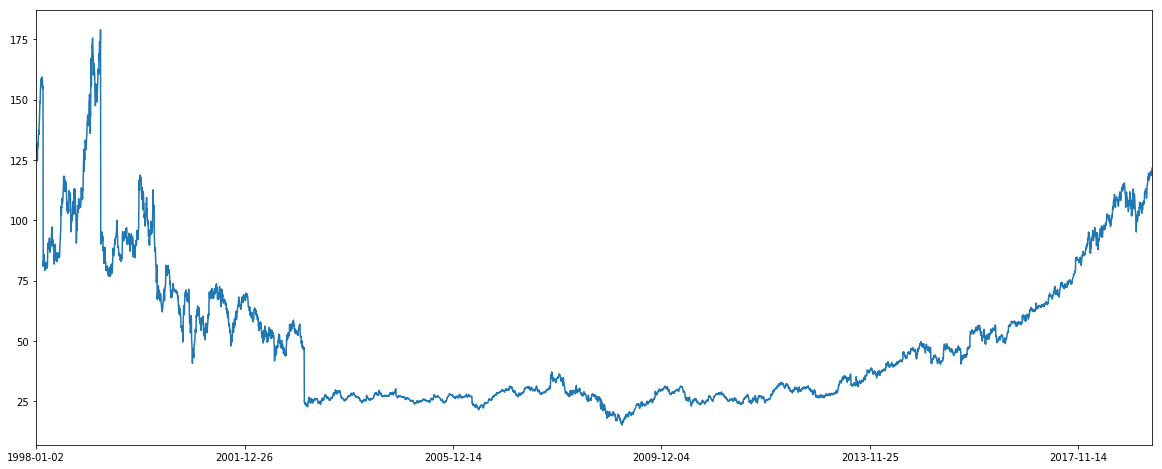

In [10]:
all_open = stock_dataset['open']
all_open.plot(figsize = (20,8))

## Exponential Moving Average
$$x_{t+1} = EMA_{t} = γ × EMA_{t-1} + (1-γ)x_{t}$$

Using Pandas to calculate a 20-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.

If Exponential Moving Average is this Good, Why do You Need Better Models?

You see that it fits a perfect line that follows the True distribution (and justified by the very low MSE). Practically speaking, you can't do much with just the stock market value of the next day. Personally what I'd like is not the exact stock market price for the next day, but would the stock market prices go up or down in the next 30 days. Try to do this, and you will expose the incapability of the EMA method.




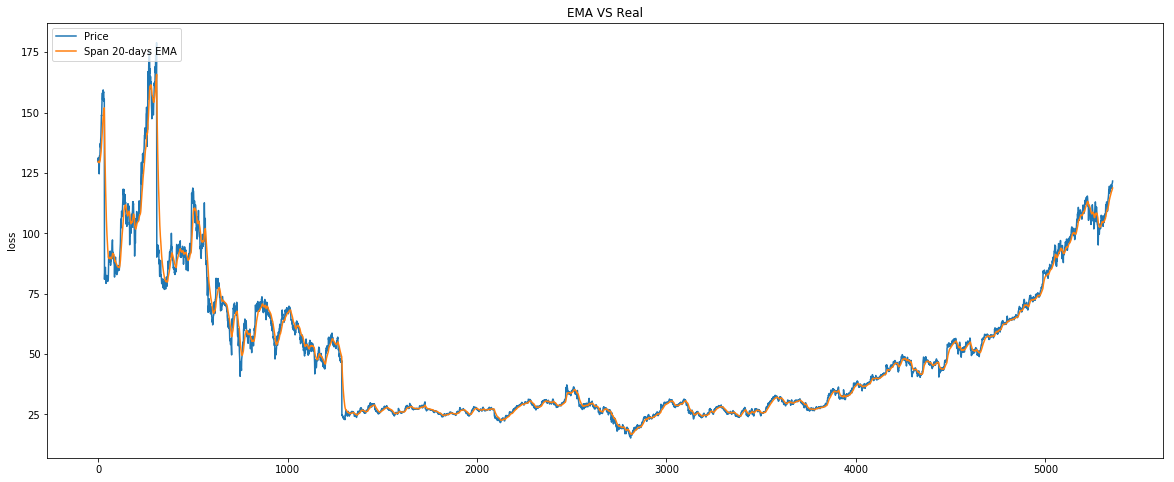

In [11]:
ema_short = all_open.ewm(span=20, adjust=False).mean()


plt.figure(figsize=(20,8))

plt.plot(all_open.values.tolist())  
plt.plot(ema_short.values.tolist())  
plt.title('EMA VS Real')  
plt.ylabel('loss')   
plt.legend(['Price','Span 20-days EMA'], loc='upper left')  
plt.show()  

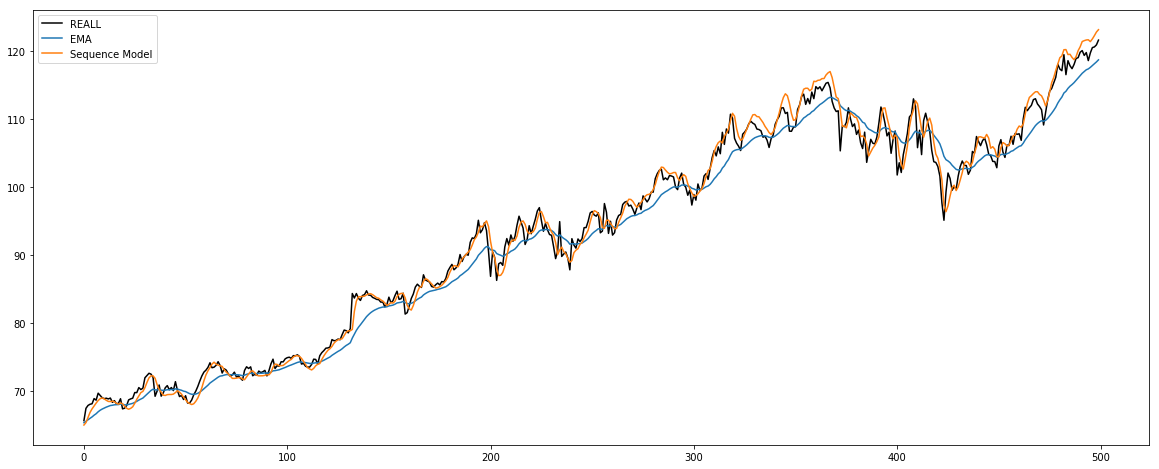

<Figure size 432x288 with 0 Axes>

In [29]:
plt.figure(figsize=(20,8))

plt.plot(all_open.values.tolist()[-500:],color = 'black')  
plt.plot(ema_short.values.tolist()[-500:]) 
plt.plot(adjusted_predicted[-500:])
  
plt.legend(['REALL', 'EMA', 'Sequence Model'], loc='upper left')  
plt.show()  
plt.savefig("EMA.png")

## Bearing this in mind, it is natural to assume that when a change in the long term behaviour of the asset occurs, the actual price timeseries will react faster than the EMA one

In [12]:
mean_ = stock_dataset.mean()
std_ = stock_dataset.std()
mean_,std_

(open      4.980968e+01
 high      5.041612e+01
 low       4.920335e+01
 close     4.982407e+01
 volume    4.726055e+07
 dtype: float64, open      3.005376e+01
 high      3.049575e+01
 low       2.958611e+01
 close     3.007582e+01
 volume    2.875712e+07
 dtype: float64)

In [13]:
stock_dataset = stock_dataset.apply(lambda x : (x - mean_) / std_, axis = 1)

In [14]:
stock_dataset.shape

(5356, 5)

In [15]:
features = []
y = []
window_size = 50
predicted_size = 1

for i in range(stock_dataset.shape[0] - window_size - predicted_size + 1):
    features.append(stock_dataset.iloc[i:i+window_size,:].values)
    y.append(stock_dataset.iloc[i+window_size,0])

features, y = np.asarray(features), np.asarray(y)
features.shape,y.shape
#features = np.reshape(features, (features.shape[0], features.shape[1], features.shape[2]))

((5306, 50, 5), (5306,))

In [21]:
split_index = int(features.shape[0]*(1-0.2))
X_train, X_test = features[0:split_index],features[split_index:]
y_train,y_test = y[0:split_index],y[split_index:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4244, 50, 5) (4244,)
(1062, 50, 5) (1062,)


In [22]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(rate = 0.2))

# model.add(LSTM(units = 128, return_sequences = False))
# model.add(Dropout(rate = 0.5))

# model.add(LSTM(units = 50, return_sequences = False))
# model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ["mse"])

In [50]:
history = model.fit(
    X_train, 
    y_train, 
    epochs = 10, 
    batch_size = 32,
    validation_data=(X_test,y_test)
)
model.save('my_model.h5')

Train on 4244 samples, validate on 1061 samples
Epoch 1/10
4244/4244 [==============================] - 14s 3ms/step - loss: 0.0659 - mean_squared_error: 0.0659 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 2/10
4244/4244 [==============================] - 12s 3ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 3/10
4244/4244 [==============================] - 11s 3ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 4/10
4244/4244 [==============================] - 11s 3ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 5/10
4244/4244 [==============================] - 11s 3ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 6/10
4244/4244 [==============================] - 12s 3ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.

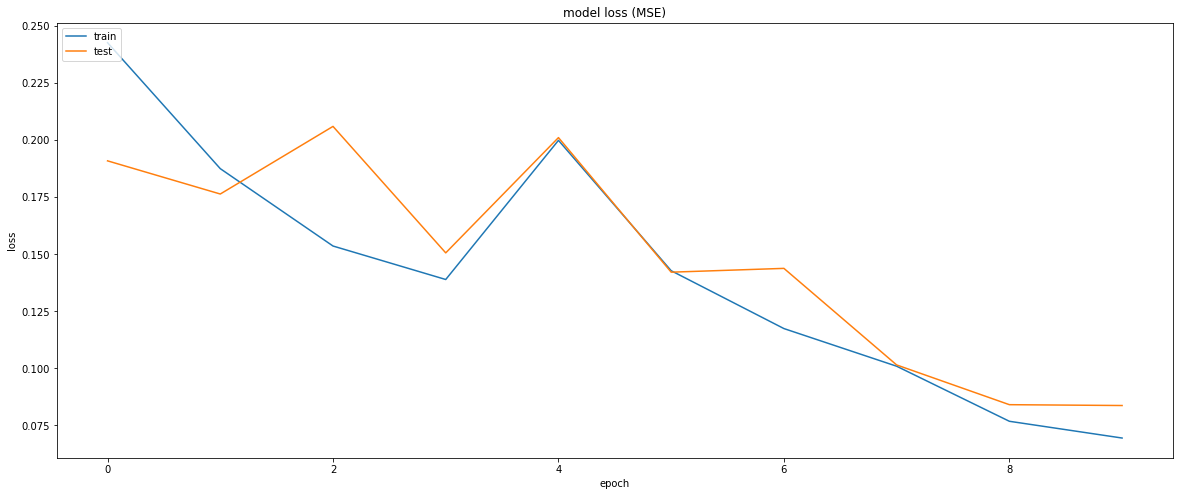

In [148]:
plt.figure(figsize = (20,8))  
   
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss (MSE)')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.savefig("loss.png")
plt.show() 

In [23]:
model = load_model('my_model.h5')

Instructions for updating:
Use tf.cast instead.


In [24]:
predict_stcok = model.predict(X_test)

In [25]:
adjusted_predicted = (predict_stcok * std_["open"] ) + mean_["open"]
adjusted_predicted = adjusted_predicted.reshape((adjusted_predicted.shape[0])).tolist()
adjusted_y_true = (stock_dataset["open"]* std_["open"] + mean_["open"])[-len(adjusted_predicted):].values

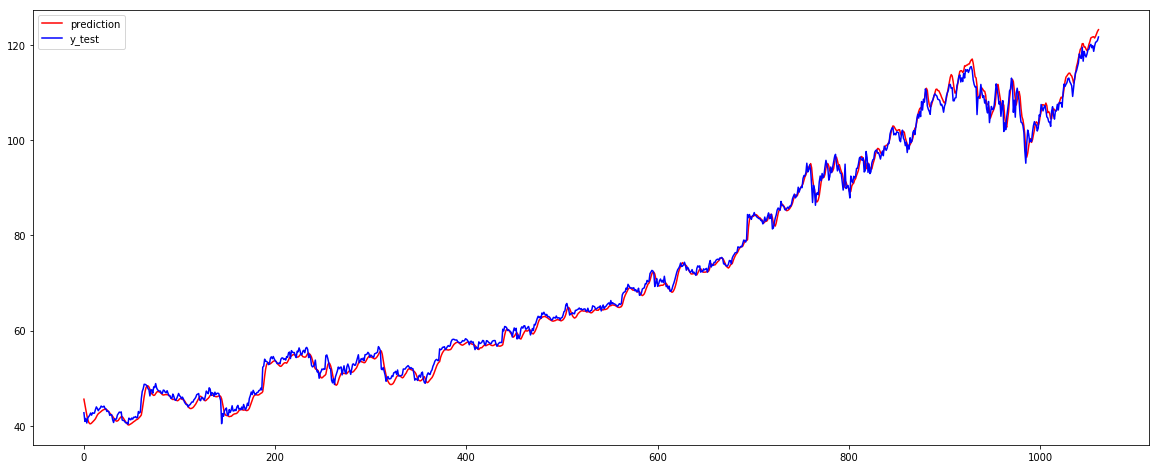

In [26]:
plt.figure(figsize = (20,8))

plt.plot(adjusted_predicted,color='red', label='prediction')
plt.plot(adjusted_y_true,color='blue', label='y_test')
plt.legend(loc='upper left')

plt.savefig("img2.png")

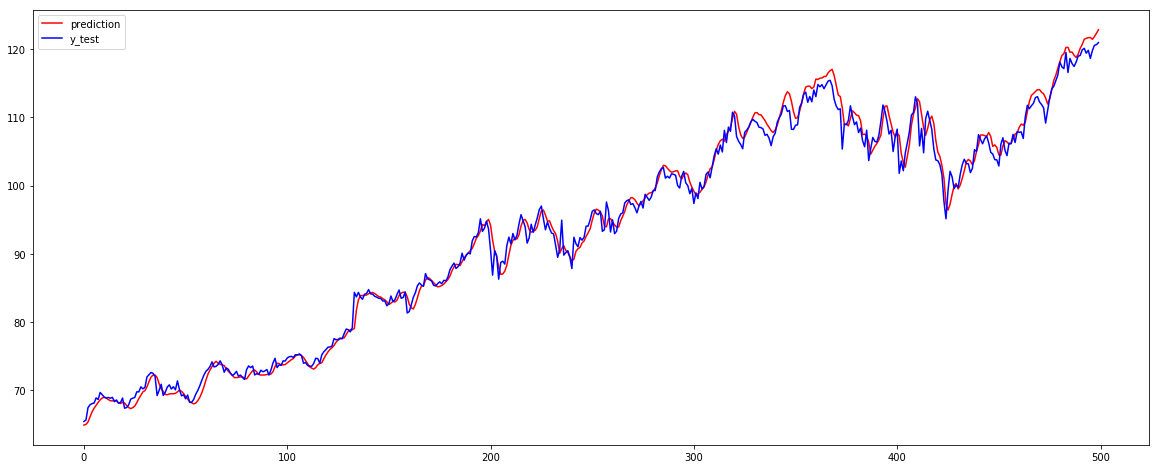

In [141]:
plt.figure(figsize = (20,8))

plt.plot(adjusted_predicted[-500:],color='red', label='prediction')
plt.plot(adjusted_y_true[-500:],color='blue', label='y_test')
plt.legend(loc='upper left')

plt.savefig("img2.png")

## difference between daily predicted price and real price (1062 days) 

In [22]:
abs(np.sum(np.array(adjusted_predicted) - np.array(adjusted_y_true)) / len(adjusted_predicted))

0.24486703823398515

## save the predicted price

In [35]:
pred = (stock_dataset.shape[0] - len(adjusted_predicted)) * [0] + adjusted_predicted

In [37]:
pd.Series(pred).to_json("predicted.json")

## seq2seq
Context Vector: The encoded representation of the source document provided by the encoder

In [98]:
num_encoder_tokens = 50
num_decoder_tokens = 10


encoder_input_data = []
decoder_input_data = []
y = []

for i in range(stock_dataset.shape[0] - num_encoder_tokens - num_decoder_tokens + 1):
    encoder_input_data.append(stock_dataset.iloc[i : i + num_encoder_tokens,:].values)
    decoder_input_data.append(stock_dataset.iloc[i + num_encoder_tokens : i + num_encoder_tokens + num_decoder_tokens].values)
    y.append( np.mean( decoder_input_data[-1][0] - encoder_input_data[-1][0][-1]))
    
encoder_input_data, decoder_input_data, y = np.asarray(encoder_input_data), np.asarray(decoder_input_data), np.asarray(y)
encoder_input_data.shape,decoder_input_data.shape, y.shape
#features = np.reshape(features, (features.shape[0], features.shape[1], features.shape[2]))

((5296, 50, 5), (5296, 10, 5), (5296,))

In [120]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, 5))
encoder = LSTM(units=50, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, 5))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(units=50, return_sequences=False, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(units=1)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [125]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=["mse"])
history = model.fit([encoder_input_data, decoder_input_data], y,
          batch_size=32,
          validation_split=0.2,
          epochs=10)

Train on 4236 samples, validate on 1060 samples
Epoch 1/10
4236/4236 [==============================] - 10s 2ms/step - loss: 0.2427 - mean_squared_error: 0.2427 - val_loss: 0.1909 - val_mean_squared_error: 0.1909
Epoch 2/10
4236/4236 [==============================] - 6s 1ms/step - loss: 0.1875 - mean_squared_error: 0.1875 - val_loss: 0.1764 - val_mean_squared_error: 0.1764
Epoch 3/10
4236/4236 [==============================] - 6s 1ms/step - loss: 0.1536 - mean_squared_error: 0.1536 - val_loss: 0.2060 - val_mean_squared_error: 0.2060
Epoch 4/10
4236/4236 [==============================] - 6s 1ms/step - loss: 0.1389 - mean_squared_error: 0.1389 - val_loss: 0.1506 - val_mean_squared_error: 0.1506
Epoch 5/10
4236/4236 [==============================] - 6s 1ms/step - loss: 0.1999 - mean_squared_error: 0.1999 - val_loss: 0.2011 - val_mean_squared_error: 0.2011
Epoch 6/10
4236/4236 [==============================] - 6s 1ms/step - loss: 0.1428 - mean_squared_error: 0.1428 - val_loss: 0.1421 

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, 5))
encoder = LSTM(units=50, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, 5))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(units=50, return_sequences=False, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(units=1)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

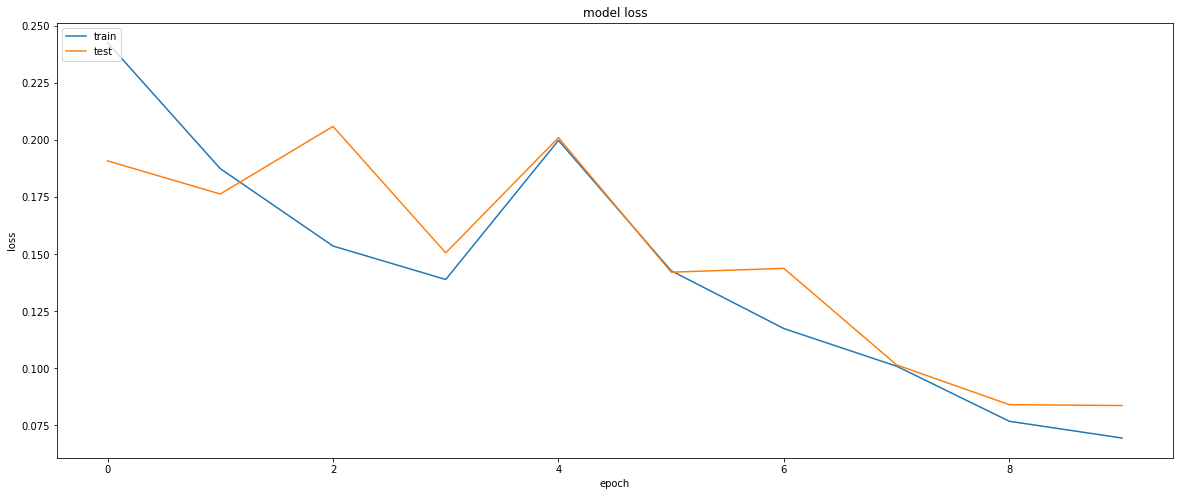

In [127]:
plt.figure(figsize = (20,8))  
   
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.savefig("loss.png")
plt.show() 

In [ ]:
ncoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence